In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

In [2]:
img_height, img_width = (224,224)
batch_size = 16

train_data_dir = r"./DataSplit/train"
valid_data_dir = r"./DataSplit/val"
test_data_dir = r"./DataSplit/test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  validation_split = 0.2,
                                  horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training')

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                   target_size = (img_height,img_width),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   subset = 'validation')

Found 219 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [4]:
train_generator.num_classes

4

In [5]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                  target_size = (img_height,img_width),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',)

Found 92 images belonging to 4 classes.


In [6]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [7]:
base_model = ResNet50(include_top=False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

obj = model.fit(train_generator,validation_data=valid_generator, epochs = 5)

2022-04-30 00:39:09.138078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-30 00:39:11.839992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
14/14 [==============================] - 25s 2s/step - loss: 1.9672 - accuracy: 0.5571 - val_loss: 0.7312 - val_accuracy: 0.7778
Epoch 2/5
14/14 [==============================] - 22s 2s/step - loss: 0.3824 - accuracy: 0.8721 - val_loss: 0.1591 - val_accuracy: 0.9444
Epoch 3/5
14/14 [==============================] - 22s 2s/step - loss: 0.1251 - accuracy: 0.9543 - val_loss: 0.0482 - val_accuracy: 1.0000
Epoch 4/5
14/14 [==============================] - 22s 2s/step - loss: 0.1002 - accuracy: 0.9772 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 5/5
14/14 [==============================] - 21s 1s/step - loss: 0.0410 - accuracy: 0.9954 - val_loss: 0.3180 - val_accuracy: 0.9444


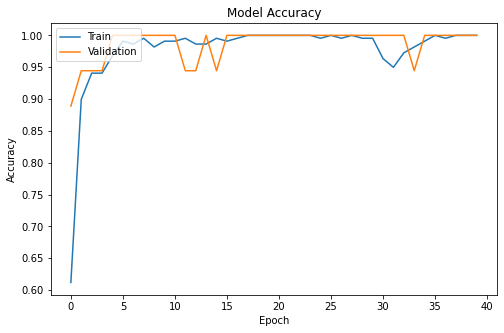

In [8]:
plt.figure(figsize=(8,5))

plt.plot(obj.history['accuracy'])
plt.plot(obj.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [9]:
# model.save(r"./Models/ResNet50.h5")


In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print("\nTest accuracy: ",test_acc)

92/92 - 12s - loss: 0.1236 - accuracy: 0.9565

Test accuracy:  0.95652174949646


2022-03-14 22:40:29.201339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


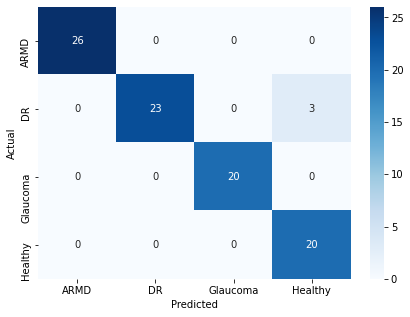

In [8]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model(r"./Models/ResNet50.h5")
filenames = test_generator.filenames


nb_samples = len(test_generator)
y_prob = []
y_act = []
figure(figsize=(7, 5))
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]



out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True, fmt='d' )

plt.show()


In [12]:
correctPredictions = {'ARMD' : confusion_matrix['ARMD']['ARMD'], 'DR' : confusion_matrix['DR']['DR'], 'Glaucoma' : confusion_matrix['Glaucoma']['Glaucoma'], 'Healthy' : confusion_matrix['Healthy']['Healthy']}


In [23]:
deNames = ['ARMD','DR','Glaucoma','Healthy']
totalCases = {'ARMD' : 0,'DR' : 0,'Glaucoma': 0,'Healthy': 0}
for name in deNames:
    for i in range(0,len(confusion_matrix[name])):
        if(i == 0):
            totalCases['ARMD'] += confusion_matrix[name][i]
        elif(i == 1):
            totalCases['DR'] += confusion_matrix[name][i]
        elif(i == 2):
            totalCases['Glaucoma'] += confusion_matrix[name][i]
        else:
            totalCases['Healthy'] += confusion_matrix[name][i]
print(totalCases)

{'ARMD': 26, 'DR': 26, 'Glaucoma': 20, 'Healthy': 20}


In [29]:
print("Test Accuracies : \n")
print("ARMD      :",correctPredictions['ARMD']/totalCases['ARMD'])
print("DR        :",correctPredictions['DR']/totalCases['DR'])
print("Glaucoma  :",correctPredictions['Glaucoma']/totalCases['Glaucoma'])
print("Healthy   :",correctPredictions['Healthy']/totalCases['Healthy'])

Test Accuracies : 

ARMD      : 1.0
DR        : 0.8846153846153846
Glaucoma  : 1.0
Healthy   : 1.0


In [14]:
pd.set_option('display.max_rows', None)
print(out_df)

   predicted_class actual_class
0          Healthy      Healthy
1               DR           DR
2             ARMD         ARMD
3             ARMD         ARMD
4             ARMD         ARMD
5          Healthy      Healthy
6          Healthy      Healthy
7               DR           DR
8               DR           DR
9             ARMD         ARMD
10         Healthy      Healthy
11         Healthy      Healthy
12              DR           DR
13              DR           DR
14        Glaucoma     Glaucoma
15            ARMD         ARMD
16        Glaucoma     Glaucoma
17         Healthy      Healthy
18        Glaucoma     Glaucoma
19         Healthy      Healthy
20            ARMD         ARMD
21              DR           DR
22            ARMD         ARMD
23            ARMD         ARMD
24            ARMD         ARMD
25              DR           DR
26         Healthy      Healthy
27              DR           DR
28              DR           DR
29         Healthy      Healthy
30      